## Resolve dependências

In [1]:
!pip install -q albumentations==1.4.6 opencv-python pycocotools tqdm
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q pycocotools albumentations==1.4.6 opencv-python tqdm
!pip uninstall -y sympy
!pip install sympy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 6.0 MB/s eta 0:00:00
Found existing installation: sympy 1.13.3
Uninstalling sympy-1.13.3:
  Successfully uninstalled sympy-1.13.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.5 MB/s eta 0:00:00


In [2]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.24.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 694356, done.
remote: Counting objects: 100% (1694/1694), done.
remote: Compressing objects: 100% (880/880), done.
remote: Total 694356 (delta 1525), reused 887 (delta 806), pack-reused 692662 (from 3)
Receiving objects: 100% (694356/694356), 1.22 GiB | 38.93 MiB/s, done.
Resolving deltas: 100% (650252/650252), done.
fatal: not a git repository (or any of the parent directories): .git


In [3]:
import sys
# sys.path.append("/content/drive/MyDrive/TCC/src/")
sys.path.append("/content/drive/MyDrive/TCC/notebooks/Faster R-CNN")

In [4]:
from pathlib import Path

DATASET_ROOT = Path("/content/drive/MyDrive/TCC/DATASET")
paths = {
    "bh_pools": {
        "images": {
            "train": DATASET_ROOT/"bh_pools/images/train",
            "val":   DATASET_ROOT/"bh_pools/images/val",
            "test":  DATASET_ROOT/"bh_pools/images/test",
        },
        "ann": {
            "train": DATASET_ROOT/"bh_pools/annotations/instances_train.json",
            "val":   DATASET_ROOT/"bh_pools/annotations/instances_val.json",
            "test":  DATASET_ROOT/"bh_pools/annotations/instances_test.json",
        }
    }
}

In [5]:
import sys
from pathlib import Path
sys.path.append("/content/drive/MyDrive/TCC/src/")
DATASET_ROOT = Path("/content/drive/MyDrive/TCC/campinas_pool_dataset")

campinas_paths = {
    "bh_watertanks": {
        "images": {
            "train": DATASET_ROOT/"train/images/",
            "test":  DATASET_ROOT/"test/images/",
        },
        "ann": {
            "train": DATASET_ROOT/"train/annotations/instances_train.json",
            "test":  DATASET_ROOT/"test/annotations/instances_test.json",
        }
    }
}

## Carrega Loaders

In [6]:
from my_utils.coco_dataset import CocoDetDataset
from my_utils.my_utils import get_transforms, collate_fn, evaluate_and_visualize
from torch.utils.data import Dataset, DataLoader


pools_train = CocoDetDataset(
    paths["bh_pools"]["images"]["train"],
    paths["bh_pools"]["ann"]["train"],
    transforms=get_transforms(train=True))

pools_val   = CocoDetDataset(
    paths["bh_pools"]["images"]["val"],
    paths["bh_pools"]["ann"]["val"],
    transforms=get_transforms(train=False))

pools_test  = CocoDetDataset(
    paths["bh_pools"]["images"]["test"],
    paths["bh_pools"]["ann"]["test"],
    transforms=get_transforms(train=False))

pools_train_loader = DataLoader(pools_train, batch_size=2, shuffle=True,  num_workers=2, collate_fn=collate_fn, pin_memory=True)
pools_val_loader   = DataLoader(pools_val,   batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)
pools_test_loader  = DataLoader(pools_test,  batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)

campinas_pools_train = CocoDetDataset(
    campinas_paths["bh_watertanks"]["images"]["train"],
    campinas_paths["bh_watertanks"]["ann"]["train"],
    transforms=get_transforms(train=True))

campinas_pools_test  = CocoDetDataset(
    campinas_paths["bh_watertanks"]["images"]["test"],
    campinas_paths["bh_watertanks"]["ann"]["test"],
    transforms=get_transforms(train=False))


campinas_pools_train_loader = DataLoader(campinas_pools_train, batch_size=2, shuffle=True,  num_workers=2, collate_fn=collate_fn, pin_memory=True)
campinas_pools_test_loader  = DataLoader(campinas_pools_test,  batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)

print("campinas-pools:", len(campinas_pools_train), len(campinas_pools_test))

loading annotations into memory...
Done (t=3.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
campinas-pools: 52 22


## Inicializa model

In [7]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 1 + 2

weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:00<00:00, 230MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [8]:
checkpoint_path = '/content/drive/MyDrive/TCC/checkpoints/fasterrcnn_pools_focused.pth'
state = torch.load(checkpoint_path)
model.load_state_dict(state)

<All keys matched successfully>

## Treina modelo

In [9]:
from torch.cuda.amp import GradScaler
scaler = GradScaler()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.002,
    momentum=0.9,
    weight_decay=5e-4
)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10,
    eta_min=1e-5
)



/tmp/ipython-input-776831819.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
from engine import train_one_epoch

num_epochs = 10

for epoch in range(num_epochs):
  if epoch == 3:
    for p in model.backbone.body.parameters():
      p.requires_grad = True
    new_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(new_params, lr=0.002, momentum=0.9, weight_decay=5e-4)

  train_one_epoch(model, optimizer, campinas_pools_train_loader, device, epoch, print_freq=10)
  lr_scheduler.step()

/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/26]  eta: 0:01:39  lr: 0.000082  loss: 0.2745 (0.2745)  loss_classifier: 0.0997 (0.0997)  loss_box_reg: 0.0485 (0.0485)  loss_objectness: 0.0990 (0.0990)  loss_rpn_box_reg: 0.0273 (0.0273)  time: 3.8102  data: 1.0862  max mem: 2783
Epoch: [0]  [10/26]  eta: 0:00:10  lr: 0.000881  loss: 0.2453 (0.2194)  loss_classifier: 0.0471 (0.0557)  loss_box_reg: 0.0195 (0.0263)  loss_objectness: 0.1211 (0.1256)  loss_rpn_box_reg: 0.0106 (0.0118)  time: 0.6634  data: 0.2105  max mem: 2982
Epoch: [0]  [20/26]  eta: 0:00:03  lr: 0.001680  loss: 0.1681 (0.1872)  loss_classifier: 0.0338 (0.0460)  loss_box_reg: 0.0284 (0.0306)  loss_objectness: 0.0933 (0.1009)  loss_rpn_box_reg: 0.0077 (0.0097)  time: 0.4140  data: 0.1886  max mem: 2982
Epoch: [0]  [25/26]  eta: 0:00:00  lr: 0.002000  loss: 0.1474 (0.1734)  loss_classifier: 0.0273 (0.0416)  loss_box_reg: 0.0333 (0.0341)  loss_objectness: 0.0641 (0.0886)  loss_rpn_box_reg: 0.0052 (0.0091)  time: 0.4652  data: 0.2399  max mem: 2982
Epoch: [

In [16]:
checkpoint_path = '/content/drive/MyDrive/TCC/notebooks/Faster R-CNN/pools/model/finetuning_c_23.pth'
torch.save(model.state_dict(), checkpoint_path)

## Avalia Modelo

In [12]:
from my_utils.my_utils import evaluate_ap_multi_iou
import numpy as np

csv_path = "/content/drive/MyDrive/TCC/notebooks/Faster R-CNN/pools/results_fine_tuning.csv"
df_results = evaluate_ap_multi_iou(
    model=model,
    loader=campinas_pools_test_loader,
    device=device,
    score_thr=0.25,
    iou_list=(0.50, 0.75, 0.90),
    iou_grid=np.arange(0.50, 0.96, 0.05),
    out_csv_path=csv_path
)

==== Resultados por classe ====
Classe 1 | mAP[.50:.95]=0.760 | AP@0.50=0.939 | AP@0.75=0.903 | AP@0.90=0.447 (GT=24)

📊 CSV salvo em: /content/drive/MyDrive/TCC/notebooks/Faster R-CNN/pools/results_fine_tuning.csv


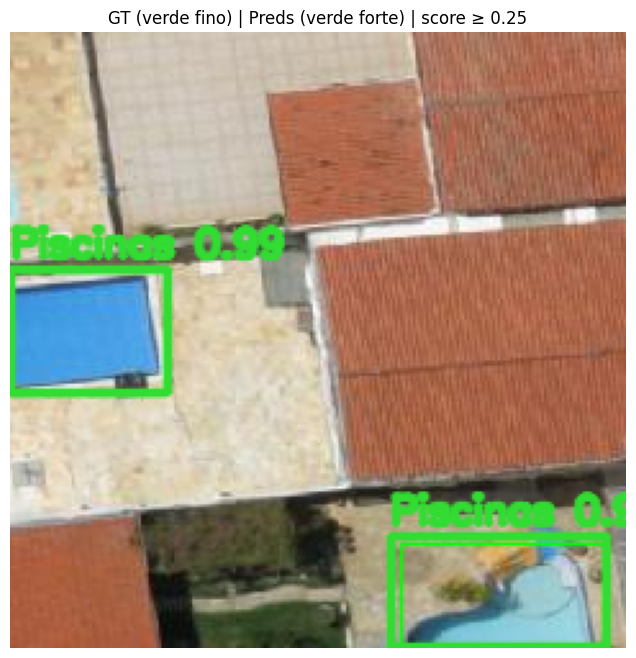

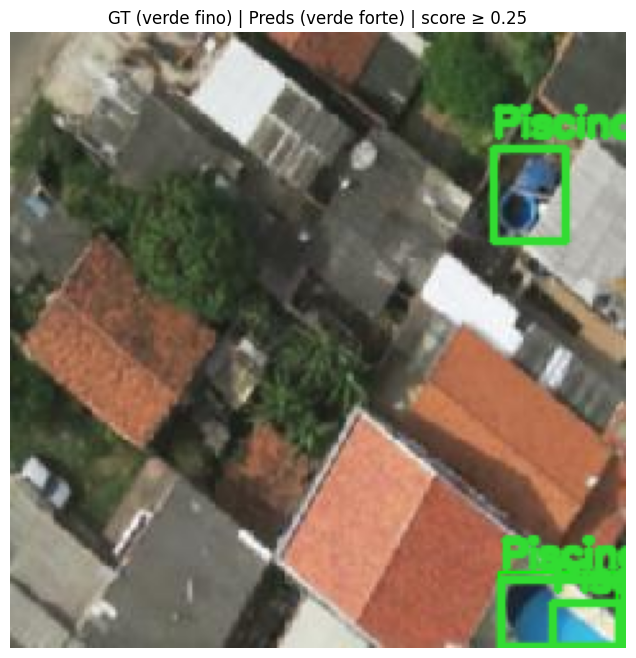

In [14]:
from my_utils.my_utils import show_predictions

show_predictions(
    model=model,
    loader=campinas_pools_test_loader,
    device=device,
    n=2,
    score_thr=0.25
)
